## Random sample imputation

Imputation is the act of replacing missing data with statistical estimates of the missing values. The goal of any imputation technique is to produce a **complete dataset** that can then be then used for machine learning.

Random sampling imputation is in principle similar to mean/median imputation, in the sense that it aims to preserve the statistical parameters of the original variable, for which data is missing.

Random sampling consist of taking a random observation from the pool of available observations of the variable, and using that randomly extracted value to fill the NA. In Random Sampling one takes as many random observations as missing values are present in the variable.

By random sampling observations of the variable for those instances where data is available, we guarantee that the mean and standard deviation of the variable are preserved.


### Assumptions

**Random sample imputation assumes that the data are missing completely at random (MCAR).** If this is the case, it makes sense to substitute the missing values, by values extracted from the original variable distribution. 

From a probabilistic  point of view, values that are more frequent (like the mean or the median) will be selected more often (because there are more of them to select from), but other less frequent values will be selected as well. Thus, the variance of the variable is preserved. 

The rationale is to replace the population of missing values with a population of values with the same distribution of the variable.


### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Preserves the variance of the variable

### Limitations

- Randomness (Can't not be reproducable)

Randomness may not seem much of a concern when replacing missing values for data competitions, where the whole batch of missing values is replaced once and then the dataset is scored and that is the end of the problem. However, **in business scenarios the situation is very different.**

Imagine for example the scenario of Mercedes-Benz, where they are trying to predict how long a certain car will be in the garage before it passes all the security tests. Today, they receive a car with missing data in some of the variables, they run the machine learning model to predict how long this car will stay in the garage, the model replaces missing values by a random sample of the variable and then produces an estimate of time. Tomorrow, when they run the same model on the same car, the model will randomly assign values to the missing data, that may or may not be the same as the ones it selected today, therefore, the final estimation of time in the garage, may or may not be the same as the one obtained the day before.

In addition, imagine also that Mercedes-Benz evaluates 2 different cars that have exactly the same values for all of the variables, and missing values in exactly the same subset of variables. They run the machine learning model for each car, and because the missing data is randomly filled with values, the 2 cars, that are exactly the same, may end up with different estimates of time in the garage. 

This may sound completely trivial and unimportant, however, businesses must follow a variety of regulations, and some of them require that the same treatment be provided to the same situation. So if instead of cars, these were people applying for a loan, or people seeking some disease treatment, the machine learning model would end up providing different solutions to candidates that are otherwise in the same conditions. And this is not fair or acceptable.

It is still possible to replace missing data by random sample, but these randomness needs to be controlled, so that individuals in the same situation end up with the same scores and therefore solutions.

Finally, another potential limitation of random sampling, similarly to replacing with the mean and median, is that estimates of covariance and correlations with other variables in the dataset may also be washed off by the randomness.

### Final note

Replacement of missing values by random sample, although similar in concept to replacement by the median or mean, <font color=red>is not as widely used in the data science community as the mean/median imputation, presumably because of the element of randomness.</font>

However, it is a valid approach, with advantages over mean/median imputation as it preserves the distribution of the variable. And if you are mindful of the element of randomness and account for it somehow, this may as well be your method of choice.

===============================================================================

## Real Life example: 

### Predicting Survival on the Titanic: understanding society behaviour and beliefs

Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

=============================================================================

In the following cells, I will show random sampling imputation on the Titanic dataset from Kaggle.

If you haven't downloaded the datasets yet, in the lecture "Guide to setting up your computer" in section 1, you can find the details on how to do so.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# for classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# to split and standarise the datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# to evaluate classification models
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
%cd ../data_set/
# load the Titanic Dataset with a few variables for demonstration

data = pd.read_csv('titanic.csv', usecols = ['Age', 'Fare', 'Survived'])
data.head()

/home/pat/Desktop/Udemy_FeatureEngineering/data_set


,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [4]:
# let's look at the percentage of NA

data.isnull().mean()

Survived    0.000000
Age         0.198653
Fare        0.000000
dtype: float64

### Imputation important

<font color=red>Imputation should done over the training set, and then propagated to the test set.</font>
    This means that the random sample to be used to fill missing values both in train and test set, should be extracted from the train set.

In [5]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data, data.Survived, test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((623, 3), (268, 3))

In [6]:
# let's make a function to create 3 variables from Age:
# 1-e filling NA with median, 2- random sampling or 3- zeroes

def impute_na(df, variable, median):
    df[variable+'_median'] = df[variable].fillna(median)
    df[variable+'_zero'] = df[variable].fillna(0)
    
    # random sampling
    df[variable+'_random'] = df[variable]
    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample

In [7]:
median = X_train.Age.mean()
median

29.915338645418327

In [8]:
impute_na(X_train, 'Age', median)
X_train.head(20)

,Survived,Age,Fare,Age_median,Age_zero,Age_random
857,1,51.0,26.5500,51.000000,51.0,51.0
52,1,49.0,76.7292,49.000000,49.0,49.0
386,0,1.0,46.9000,1.000000,1.0,1.0
124,0,54.0,77.2875,54.000000,54.0,54.0
578,0,NaN,14.4583,29.915339,0.0,16.0
549,1,8.0,36.7500,8.000000,8.0,8.0
118,0,24.0,247.5208,24.000000,24.0,24.0
12,0,20.0,8.0500,20.000000,20.0,20.0
157,0,30.0,8.0500,30.000000,30.0,30.0
127,1,24.0,7.1417,24.000000,24.0,24.0


In [9]:
impute_na(X_test, 'Age', median)

#### Random sampling preserves the original distribution of the variable

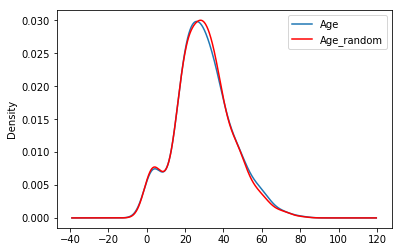

In [10]:
# we can see that the distribution of the variable after filling NA is exactly the same as that one before filling NA
fig = plt.figure()
ax = fig.add_subplot(111)
X_train['Age'].plot(kind='kde', ax=ax)
X_train.Age_random.plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

We can see that replacing missing values with a random sample from the training set preserves the original distribution of the variable.

Whereas replacing by the median only, or filling NA  with zeros, alters the distribution. See below.

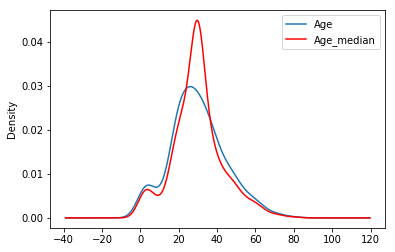

In [11]:
# we can see that the distribution has changed slightly with now more values accumulating in the median range
fig = plt.figure()
ax = fig.add_subplot(111)
X_train['Age'].plot(kind='kde', ax=ax)
X_train.Age_median.plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

Median imputation results in an increase in the number of observations with values around the median.

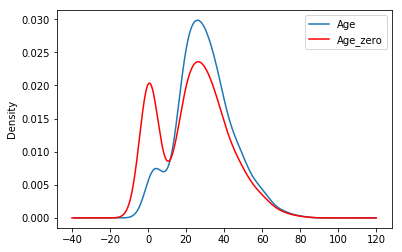

In [12]:
# filling NA with zeroes creates a peak of population around 0, as expected
fig = plt.figure()
ax = fig.add_subplot(111)
X_train['Age'].plot(kind='kde', ax=ax)
X_train.Age_zero.plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

Zero imputation results in an increase in the number of observations with values around the zero.

### Logistic Regression

In [13]:
# let's compare the performance of logistic regression on Age NA imputed by zeroes, or median or random sampling

logit = LogisticRegression(random_state=44, C=1000) # c big to avoid regularization
logit.fit(X_train[['Age_zero', 'Fare']], y_train)
print('Train set zero imputation')
pred = logit.predict_proba(X_train[['Age_zero', 'Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
print('Test set zero imputation')
pred = logit.predict_proba(X_test[['Age_zero', 'Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
print()
logit = LogisticRegression(random_state=44, C=1000) # c big to avoid regularization
logit.fit(X_train[['Age_median', 'Fare']], y_train)
print('Train set median imputation')
pred = logit.predict_proba(X_train[['Age_median', 'Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
print('Test set median imputation')
pred = logit.predict_proba(X_test[['Age_median', 'Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
print()
logit = LogisticRegression(random_state=44, C=1000) # c big to avoid regularization
logit.fit(X_train[['Age_random', 'Fare']], y_train)
print('Train set random sample imputation')
pred = logit.predict_proba(X_train[['Age_random', 'Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
print('Test set random sample imputation')
pred = logit.predict_proba(X_test[['Age_random', 'Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Train set zero imputation
Logistic Regression roc-auc: 0.686346283160886
Test set zero imputation
Logistic Regression roc-auc: 0.71375

Train set median imputation
Logistic Regression roc-auc: 0.6789494804884926
Test set median imputation
Logistic Regression roc-auc: 0.7252380952380951

Train set random sample imputation
Logistic Regression roc-auc: 0.6851369818442117
Test set random sample imputation
Logistic Regression roc-auc: 0.7121130952380953


We can see that replacing the NA with a random sample of the dataset, does not perform as well as when replacing with the median. However, this is entirely due to randomness. I invite you to change the seed (random_sate) in the impute_na function, then recreate the X_train and X_test, and you will see how the performance of logistic regression varies. In some cases, the performance will be better.

So if the performance of median imputation vs random sample imputation are similar, which method should I use?

Choosing which imputation method to use, will depend on various things:
- are NA missing completely at random?
- do you want to preserve the distribution of the variable?
- are you willing to accept an element of randomness in your imputation method?
- are you aiming to win a data competition? or to make business driven decisions?

There is no 'correct' answer to which imputation method you can use, it rather depends on what you are trying to achieve.


### Support Vector Machine

In [14]:
# let's compare the performance of SVMs on Age NA imputed by zeroes, or median or random sampling

SVM_model = SVC(random_state=44, probability=True, max_iter=-1, kernel='linear',)
SVM_model.fit(X_train[['Age_zero', 'Fare']], y_train)
print('Train set zero imputation')
pred = SVM_model.predict_proba(X_train[['Age_zero', 'Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
print('Test set zero imputation')
pred = SVM_model.predict_proba(X_test[['Age_zero', 'Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
print()
SVM_model = SVC(random_state=44, probability=True,  max_iter=-1, kernel='linear')
SVM_model.fit(X_train[['Age_median', 'Fare']], y_train)
print('Train set median imputation')
pred = SVM_model.predict_proba(X_train[['Age_median', 'Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
print('Test set median imputation')
pred = SVM_model.predict_proba(X_test[['Age_median', 'Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
print()
SVM_model = SVC(random_state=44, probability=True, max_iter=-1, kernel='linear')
SVM_model.fit(X_train[['Age_random', 'Fare']], y_train)
print('Train set random imputation')
pred = SVM_model.predict_proba(X_train[['Age_random', 'Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
print('Test set random imputation')
pred = SVM_model.predict_proba(X_test[['Age_random', 'Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Train set zero imputation
Logistic Regression roc-auc: 0.6879351857877269
Test set zero imputation
Logistic Regression roc-auc: 0.7243452380952381

Train set median imputation
Logistic Regression roc-auc: 0.6935803995574932
Test set median imputation
Logistic Regression roc-auc: 0.7417261904761905

Train set random imputation
Logistic Regression roc-auc: 0.6993340708444502
Test set random imputation
Logistic Regression roc-auc: 0.7396130952380953


For SVM as well, median imputation or random sample imputation work better than replacing NA with zeroes. But keep in mind that because random sample is precisely, random, if you had randomly selected a different bunch of values to replace the NA in Age, the last SVM roc-auc, might have been different.

Why median imputation works better than zero imputation was discussed in the previous lecture "Replacing NA by mean or median". I invite you to go back to that notebook and have a look if you haven't.

### Random Forests

In [15]:
# let's compare the performance of Random Forests on Age NA imputed by zeroes, or median or random sampling

rf = RandomForestClassifier(n_estimators=100, random_state=39, max_depth=3)
rf.fit(X_train[['Age_zero', 'Fare']], y_train)
print('Train set zero imputation')
pred = rf.predict_proba(X_train[['Age_zero', 'Fare']])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
print('Test set zero imputation')
pred = rf.predict_proba(X_test[['Age_zero', 'Fare']])
print('Random Forests zero imputation roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
print()
rf = RandomForestClassifier(n_estimators=100, random_state=39, max_depth=3)
rf.fit(X_train[['Age_median', 'Fare']], y_train)
print('Train set median imputation')
pred = rf.predict_proba(X_train[['Age_median', 'Fare']])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
print('Test set median imputation')
pred = rf.predict_proba(X_test[['Age_median', 'Fare']])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
print()
rf = RandomForestClassifier(n_estimators=100, random_state=39, max_depth=3)
rf.fit(X_train[['Age_random', 'Fare']], y_train)
print('Train set random imputation')
pred = rf.predict_proba(X_train[['Age_random', 'Fare']])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
print('Test set random imputation')
pred = rf.predict_proba(X_test[['Age_random', 'Fare']])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Train set zero imputation
Random Forests roc-auc: 0.7555855621353116
Test set zero imputation
Random Forests zero imputation roc-auc: 0.7490476190476191

Train set median imputation
Random Forests roc-auc: 0.751648554261296
Test set median imputation
Random Forests roc-auc: 0.7698809523809523

Train set random imputation
Random Forests roc-auc: 0.7542027287911325
Test set random imputation
Random Forests roc-auc: 0.754375


Random Forests, as well as SVMs, perform better with median and random sampling imputation, compared with replacing with zeroes. The caveat of randomness still applies.

### Randomness can lead to different scores being assigned to the same observation

In [16]:
# let's pick one observation with NA in Age
observation = data[data.Age.isnull()].head(1)
observation

,Survived,Age,Fare
5,0,NaN,8.4583


In [19]:
# and now let's fill that NA with a random value extracted from the same variable where observations are available

obs_sample = X_train.Age.dropna().sample(1)
obs_sample.index = [5] #pandas needs the same index to be able to merge
observation['Age_random']=obs_sample
observation

,Survived,Age,Fare,Age_random
5,0,NaN,8.4583,38.0


In [20]:
# and now let's make a prediction with random forest

rf.predict_proba(observation[['Fare', 'Age_random']])[:,1]

array([0.48054102])

In [21]:
# let's repeat the exercise again: we fill the NA with another random extracted value, and make a new prediction
obs_sample = X_train.Age.dropna().sample(1)
obs_sample.index = [5]
observation['Age_random']=obs_sample
rf.predict_proba(observation[['Fare', 'Age_random']])[:,1]

array([0.48529484])

In [23]:
# and again
obs_sample = X_train.Age.dropna().sample(1)
obs_sample.index = [5]
observation['Age_random']=obs_sample
rf.predict_proba(observation[['Fare', 'Age_random']])[:,1]

array([0.46812305])

We can see that every time we repeat the operation, we get a different score, for exactly the same observation. In fact, if we repeat the process 100 times:

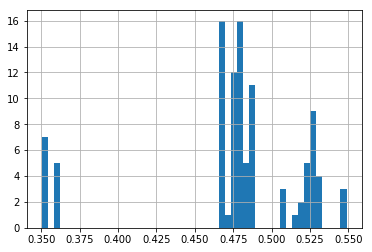

In [24]:
# if we repeat the process 100 times
predictions_ls = []
for i in range(100):
    obs_sample = X_train.Age.dropna().sample(1)
    obs_sample.index = [5]
    observation['Age_random']=obs_sample
    predictions_ls.append(float(rf.predict_proba(observation[['Fare', 'Age_random']])[:,1]))
    
pd.Series(predictions_ls).hist(bins=50)

We obtain very different values for the same observation. If this were patients looking for treatment, we would assign patients with the same characteristics to different treatments, and this is not ok.

### How can we fix this randomness?

We can fix this randomness by assigning a seed:

In [25]:
predictions_ls = []
na_replacement = []
for i in range(10):
    obs_sample = X_train.Age.dropna().sample(1, random_state=39) # we set the random seed at the moment of sampling
    obs_sample.index = [5]
    na_replacement.append(float(obs_sample))
    observation['Age_random']=obs_sample
    predictions_ls.append(float(rf.predict_proba(observation[['Fare', 'Age_random']])[:,1]))

In [26]:
# now we get the same replacement every single time
na_replacement

[19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0]

In [27]:
# and therefore we make the same prediction every single time
predictions_ls

[0.5231257238817243,
 0.5231257238817243,
 0.5231257238817243,
 0.5231257238817243,
 0.5231257238817243,
 0.5231257238817243,
 0.5231257238817243,
 0.5231257238817243,
 0.5231257238817243,
 0.5231257238817243]

However, if we set the same seed for every single observation, what would happen is that for every new observation, we would be filling the NA with exactly the same value. See below:

In [29]:
# let's find a different observation where Age is null
observation = data[data.Age.isnull()].tail(1)
observation

,Survived,Age,Fare
888,0,NaN,23.45


In [31]:
# let's replace the NA using the same seed
obs_sample = X_train.Age.dropna().sample(1, random_state=39)
obs_sample.index = [888]
observation['Age_random']=obs_sample
observation

,Survived,Age,Fare,Age_random
888,0,NaN,23.45,19.0


As you can see, we filled the NA with exactly the same value, 19, therefore, this is no longer a random sampling. The sample is indeed taken at random, but this randomness is dictated by the seed, and the seed is always the same, so we would have replaced the NA by exactly the same value, each time.

How can we prevent this?

### Controlling the element of randomness by varying the seed

We can attribute a different seed to each observation, and in fact, we can make this seed depend on an alternative variable of the same observation, thus, were 2 passengers to come, who paid exactly the same Fare, they would get exactly the same probability of survival (when Age is missing). See below:

In [32]:
# the seed is now the Fare
int(observation.Fare)

23

In [35]:
# we assign the Fare as the seed in the random sample extraction
obs_sample = X_train.Age.dropna().sample(1, random_state=int(observation.Fare))
obs_sample.index = [888]
observation['Age_random']=obs_sample
observation

,Survived,Age,Fare,Age_random
5,0,NaN,8.4583,NaN


In [36]:
# for a different observation with a different Fare, we would get a different randomly extracted value
observation = data[data.Age.isnull()].head(1)
obs_sample = X_train.Age.dropna().sample(1, random_state=int(observation.Fare))
obs_sample.index = [5]
observation['Age_random']=obs_sample
observation

,Survived,Age,Fare,Age_random
5,0,NaN,8.4583,25.0


This is a way of controlling the randomness. Using the Fare to set the random state, you guarantee that for 2 passengers with equal Fare, the Age will be replaced with the same number, and therefore the 2 passengers will get the same probability of survival.

In real life datasets, you will build models that use tens of variables or more. So in cases like those, you can think of picking the 3-5 more important variables, those that have the strongest impact on the output of the machine learning model, and combine them to create the random state. Therefore, customers that share the 3-5 main variable values, will get the same scores.

**That is all for this demonstration. I hope you enjoyed the notebook, and see you in the next one.**